In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import pandas as pd

In [6]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
sample = sample[sample["v_asym_g"]/sample["v_asym_g_err"]>3]
sample = sample[sample["v_asym_s"]/sample["v_asym_s_err"]>3]
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv")
prospect= prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]
bpt= bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp= ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]

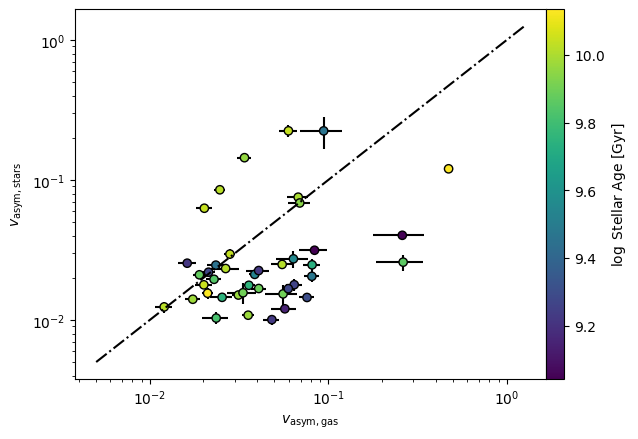

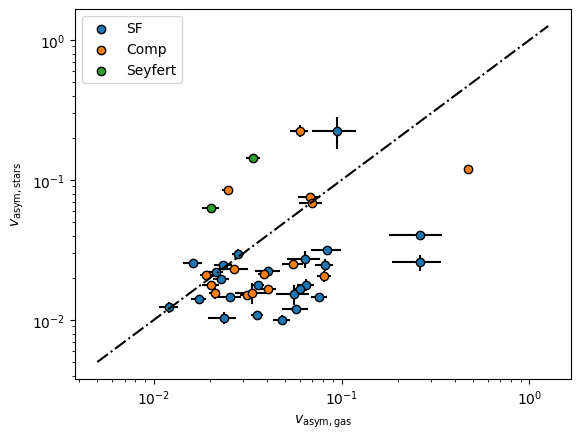

In [33]:
vg = sample["v_asym_g"].to_numpy()
vg_err = sample['v_asym_g_err'].to_numpy()
vs = sample["v_asym_s"].to_numpy()
vs_err = sample["v_asym_s_err"].to_numpy()

fig,ax = plt.subplots()
p=ax.scatter(vs,vg,ec="k",c=ssp["logage_MW_2re"].to_numpy(),zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
plt.colorbar(p,ax=ax,label=r"$\log$ Stellar Age [Gyr]",pad=0,fraction=0.05)
plt.show()

fig,ax = plt.subplots()
for i,lab in zip([1,0,2],["SF","Comp","Seyfert"]):
    ax.scatter(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==i],
               ec="k",zorder=2,label=lab)
    ax.errorbar(vs[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],vg[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                xerr=vs_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],
                yerr=vg_err[bpt['type(sf+AGN=0, sf=1, sy=2, ln=3)']==i],fmt=".k",zorder=1)
ax.plot(np.logspace(-2.3,0.1),np.logspace(-2.3,0.1),ls='dashdot',color="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v_{\rm asym,gas}$")
ax.set_ylabel(r"$v_{\rm asym,stars}$")
ax.legend()
plt.show()